# Policy Gradient Methods

In [1]:
import numpy as np
import jax.numpy as jnp
import jax.random as jrandom
from src.systems.linear import StochasticDoubleIntegrator
from src.NeuralNetwork.ANN import NeuralNet
from src.RL.PolicyGradient.REINFORCE import *
from src.controllers.utilities import *

import matplotlib.pyplot as plt
plt.style.use('ggplot')


### Aim

Policy gradient methods aim to optimize the policy parameters w.r.t. the expected cost-to-go by gradient descent.

As is the case in both Reinforcement Learning and optimal control as a whole, the aim is to find a policy $\theta$ that minimizes the optimal cost to go $J^*$.
\begin{equation}
J^*(s, \theta, t) = C(s, \theta, t) + \gamma \langle J^*(s, \theta, t+1)\rangle
\end{equation}
The marginal cost is described by the function $C(\cdot)$ with state $s$ and time $t$. Discount value $\gamma$ dimishishes the value of future cost. In order to find the policy with the optimal cost-to-go, the policy parameterization is updated according to the gradient update rule

\begin{equation}
\theta_{t+1} = \theta_t + \alpha \nabla_\theta J^*_{\theta_t}
\end{equation}

The challenge in both robotics and control is to find the gradient $\nabla_\theta J^*_{\theta_t}$. Optimal methods rely on knowledge of the system to establish this gradient. However, autonomous and adaptive systems need the ability to establish this gradient without knowing a full model of the system. The resulting challenge is to estimate the policy gradient from data generated during the execution af the task.



### Methods

First, we define a policy
\begin{equation}
\pi_\theta (u_t | s_t) \sim N(\theta s_t, \sigma)
\end{equation}

The gradient of the log then equals
\begin{equation}
\nabla_\theta \log \pi_\theta (u_t | s_t) = \frac{(\theta s_t - u_t) s_t}{\sigma}
\end{equation}

We want to update our parameters $\theta$ such that it maximally increases the expected cost-to-go. In other words, we want to perform gradient ascent on on the cost-function w.r.t the parameters $\theta$. This requeres establishing,

\begin{align}
\nabla_\theta J(\theta) &= \Big\langle \sum_{t=0}^H Q_{\pi_\theta} (s_t, u_t) \nabla_\theta \log \pi_\theta (u_t | s_t) \Big\rangle \\
&= \Big\langle Q_{\pi_\theta} (\tau) \sum_{t=0}^H \frac{(\theta s_t - u_t) s_t}{\sigma}\Big\rangle
\end{align}

in which $\tau$ represents the sampled trajectory. In order to find this expected gradient Monte-Carlo sampling is used. This gives,

\begin{equation}
\nabla_\theta J(\theta) \approx \frac{1}{N} \sum_{\tau \in N} Q_{\pi_\theta} (\tau) \sum_{t=0}^H \frac{(\theta s_t - u_t) s_t}{\sigma}
\end{equation}

**Adaptive control**

The aim is to learn the optimal policy adaptively. Therefore, there no random sampling of positions in the environment is used. Instead, the controller aims to regulate the system on the go. The controller is updated every 5 steps. Furthermore, the trajectory is sampled with only one draw.


### First the naive approach

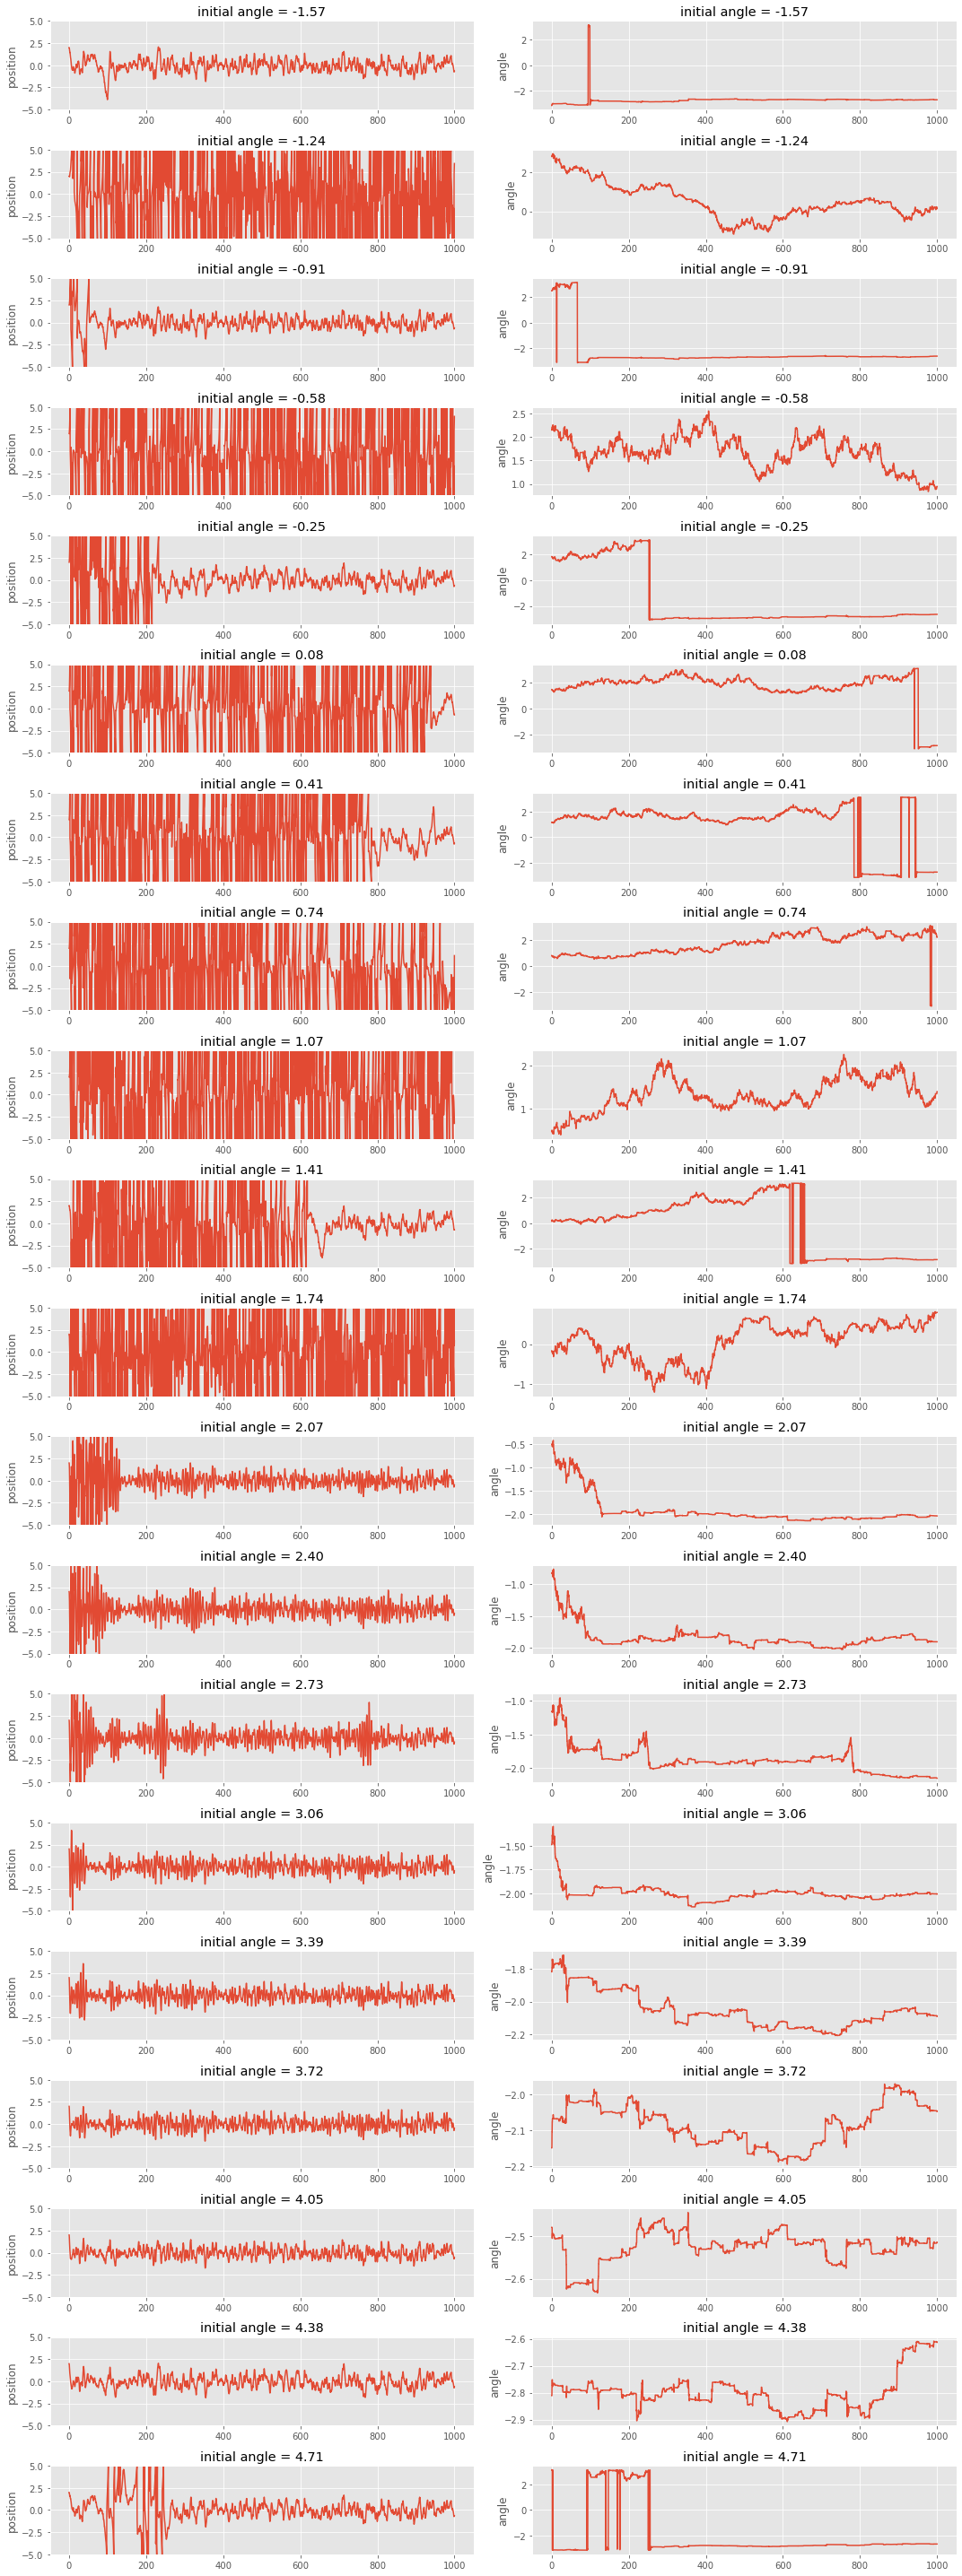

In [11]:
key = jrandom.PRNGKey(5)
fig, ax = plt.subplots(20, 2, figsize=(15, 40))

for idx, phi in enumerate(np.linspace(-np.pi/2, np.pi*1.5, 20)):
    # Initialize system
    x0 = jnp.array([2, 0])
    SDI = StochasticDoubleIntegrator(x0)

    T = 1000
    n_obs = 2

    # Initialize controller
    controller = linear_controller(key, (1, n_obs), eta=1e-3)
    controller.params = jnp.array([[jnp.cos(phi), jnp.sin(phi)]])

    # run environment
    TH, X, U, C, L, P, M, controller = run_controlled_environment(key, controller, SDI, T, training_wheels=True, method='PolicyGradient')
    
    ax[idx, 0].plot(TH, X[:, 0])
    ax[idx, 0].set_ylabel('position')
    ax[idx, 0].set_ylim([-5, 5])
    ax[idx, 1].plot(TH, P)
    ax[idx, 1].set_ylabel('angle')
    ax[idx, 0].set_title('initial angle = {:.2f}'.format(phi))
    ax[idx, 1].set_title('initial angle = {:.2f}'.format(phi))
plt.tight_layout()
plt.show()


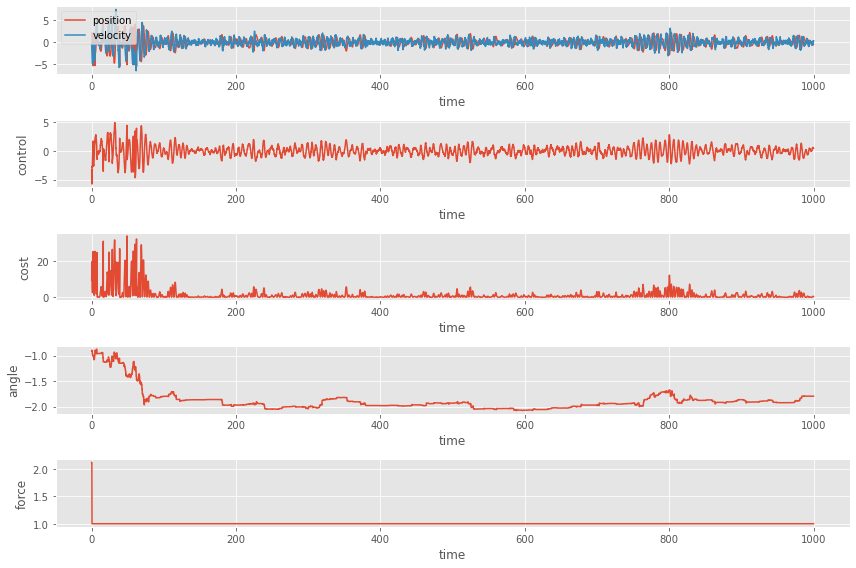

In [11]:
key = jrandom.PRNGKey(5)

# Initialize system
x0 = jnp.array([2, 0])
SDI = StochasticDoubleIntegrator(x0)

T = 1000
n_obs = 2

# Initialize controller
controller = linear_controller(key, (1, n_obs), eta=1e-3)
controller.update_interval = 5

# run environment
TH, X, U, C, L, P, M, controller = run_controlled_environment(key, controller, SDI, T, training_wheels=True, method='PolicyGradient')

fig, ax = plt.subplots(5, figsize=(12,8))
ax[0].plot(TH, X[:,0], label='position')
ax[0].plot(TH, X[:,1], label='velocity')
ax[0].legend()
ax[1].plot(TH, U)
ax[2].plot(TH, C)
ax[3].plot(TH, P)
ax[4].plot(TH, M)
labels = {'ylab': [None, 'control', 'cost', 'angle', 'force']}
for idx in range(5):
    ax[idx].set_xlabel('time')
    ax[idx].set_ylabel(labels['ylab'][idx])
plt.tight_layout()

### Test

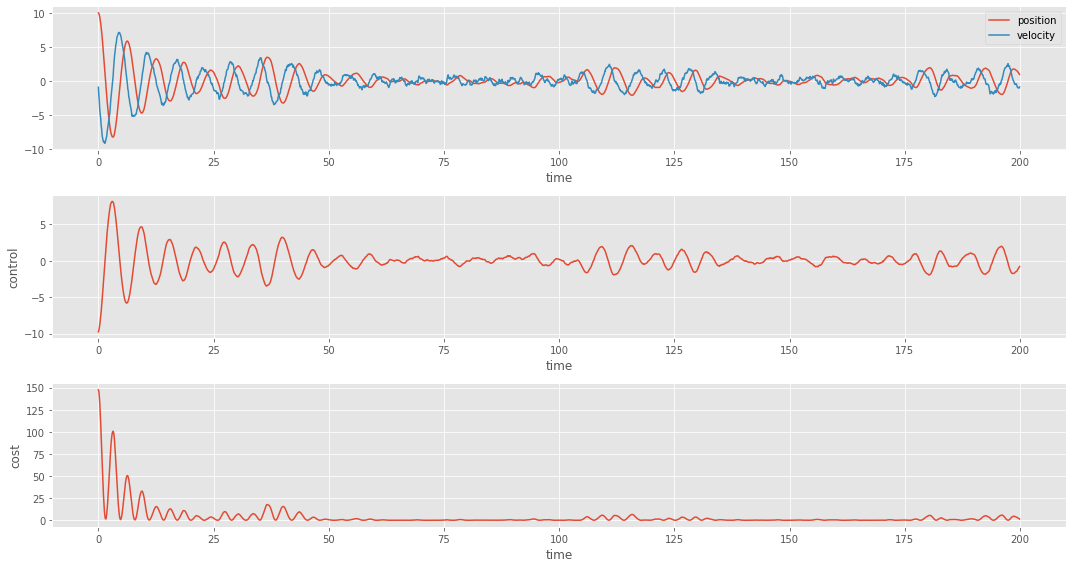

In [13]:
# Initialize system
x0 = np.array([10, 0])
SDI = StochasticDoubleIntegrator(x0)

# Run controler
th, X, U, C, _, _, _, controller = run_controlled_environment(key, controller, SDI, 200, learning=False)

fig, ax = plt.subplots(3, figsize=(15,8))
ax[0].plot(th, X[:, 0], label='position')
ax[0].plot(th, X[:, -1], label='velocity')
ax[0].legend()
ax[1].plot(th, U)
ax[2].plot(th, C)
labels = {'ylab': [None, 'control', 'cost']}
for idx in range(3):
    ax[idx].set_xlabel('time')
    ax[idx].set_ylabel(labels['ylab'][idx])
plt.tight_layout()

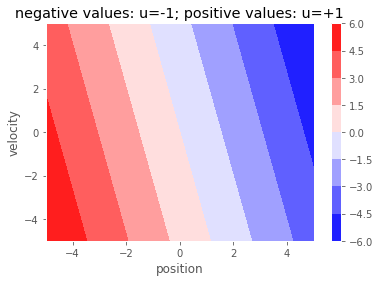

In [12]:
from matplotlib import cm
n=10
x = np.linspace(-5,5,n)
y = np.linspace(-5,5,n)
xv, yv = np.meshgrid(x,y)
z = np.zeros((n, n))
for i in range(n):
    for j in range(n):
        u_val = controller.get_control(jnp.array([xv[i,j], yv[i,j]]), optimal=True)
        z[i,j] = u_val

plt.contourf(xv, yv, z, cmap=cm.bwr)
plt.xlabel('position')
plt.ylabel('velocity')
plt.colorbar()
plt.title('negative values: u=-1; positive values: u=+1');

## DeepREINFORCE
Under construction

In [ ]:
key = jrandom.PRNGKey(2)

# Initialize system
x0 = jnp.array([2, 0])
SDI = StochasticDoubleIntegrator(x0)

T = 500
n_obs = 2

# Initialize neural network
architecture = (2, 1)
activation = ['linear']
NN = NeuralNet(key, architecture, activation, eta=1e-4)

# Initialize controller
controller = DeepREINFORCE(NN)

# run environment
TH, X, U, C, L, controller = run_controlled_environment(key, controller, SDI, T, training_wheels=True, method='PolicyGradient')

fig, ax = plt.subplots(3, figsize=(12,8))
ax[0].plot(TH, X[:,0])
ax[0].plot(TH, X[:,1])
ax[1].plot(TH, U)
ax[2].plot(TH, C)
labels = {'ylab': [None, 'control', 'cost']}
for idx in range(3):
    ax[idx].set_xlabel('time')
    ax[idx].set_ylabel(labels['ylab'][idx])
plt.tight_layout()